In [1]:
import pandas as pd
import numpy as np
from classes.TrainDataset import TrainDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
%matplotlib inline

## Plan:
- Use a pre-trained model for feature extraction
- Make pre-trained/homemade model for feature processing
- Compute 20*20 sine/cosine similarity matrix
- Select top 2 images most similar to 'left' image

### Preprocess and show

In [3]:
# Import train and test data
test_candidates = pd.read_csv('data/test_candidates.csv')
train_candidates = pd.read_csv('data/train_candidates.csv')
train_true = pd.read_csv('data/train.csv')
train_true.head()

,left,right
0,aaa,osr
1,aaz,mqw
2,abh,cdx
3,abn,uzp
4,abq,bbd


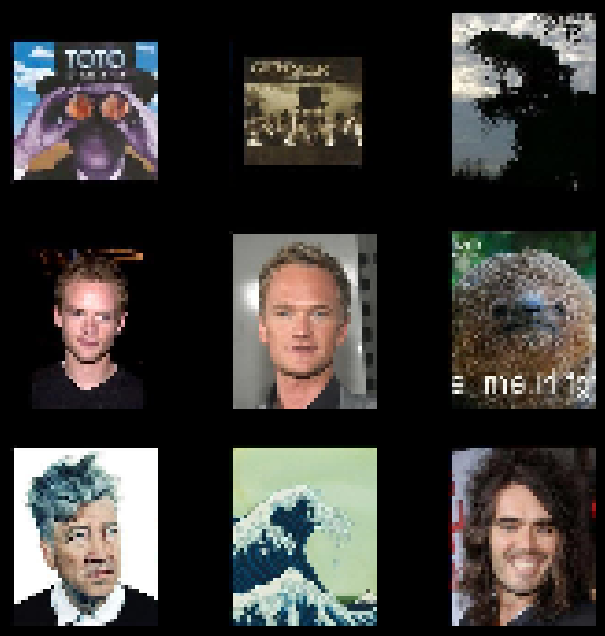

In [5]:
# Visualize Pair of matching images + a rdm image


def preprocess_image(image):
    """Original images are 200x245, normalize and downsample image to 40x49"""
    image = image.astype(np.float32) / 255.
    return image[::5, ::5]

def show(ax, fig, image_path, with_preprocess=True):
    img = mpimg.imread(image_path)
    if with_preprocess:
        img = preprocess_image(img)
    ax.imshow(img)
    ax.axis('off')

fig, axs = plt.subplots(3, 3, figsize=(8, 8), facecolor='black')

for i in range(3):
    left, right = train_true.iloc[i]
    # Pair of matching images
    show(axs[i, 0], fig, 'data/train/all/{}.jpg'.format(left))
    show(axs[i, 1], fig, 'data/train/all/{}.jpg'.format(right))
    # random image from the train set (not a true match)
    rd_img = random.sample(list(train_candidates.iloc[i].where(lambda x: ~x.isin([left, right])).dropna()), 1)[0]
    show(axs[i, 2], fig, 'data/train/all/{}.jpg'.format(rd_img))

### Cosine similarity

In [61]:
# compute cosine similartiy matrix between first image of train_candidates
# and all 20 images of the same row
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(row, with_preprocessing=True):
    """Compute cosine similarity between first image of row and all other images in row"""
    left = row.iloc[0]
    right = row.iloc[1:]
    
    # Using downsampled 40x49 images gives a very close cosine similarity to the original 200x245 images
    if with_preprocessing:
        left = preprocess_image(mpimg.imread('train/all/{}.jpg'.format(left))).flatten()
        right = [preprocess_image(mpimg.imread('train/all/{}.jpg'.format(img))).flatten() for img in right]
    else: 
        left = mpimg.imread('train/all/{}.jpg'.format(left)).flatten()
        right = [mpimg.imread('train/all/{}.jpg'.format(img)).flatten() for img in right]

    left = left.reshape(1, -1)
    right = np.array(right)
    return left, right, cosine_similarity(left, right)[0]

In [62]:
left, right, sim_matrix = compute_cosine_similarity(train_candidates.loc[0])
pred_ind = np.argmax(sim_matrix)
true_row_ind = row_idx = (train_candidates.iloc[0] == train_true.iloc[0, 1]).idxmax()
true_col_idx = list(train_candidates.columns).index(true_row_ind)
print('base img:', train_candidates.loc[0, 'left'], '/ pred:', train_candidates.loc[0, train_candidates.columns[pred_ind]], "/ dist = ", sim_matrix[pred_ind])
print('base img:', train_candidates.loc[0, 'left'], '/ true:', train_candidates.loc[0, train_candidates.columns[true_col_idx]], "/ dist = ", sim_matrix[true_col_idx])

base img: aaa / pred: vrg / dist =  0.7577027
base img: aaa / true: osr / dist =  0.3814749


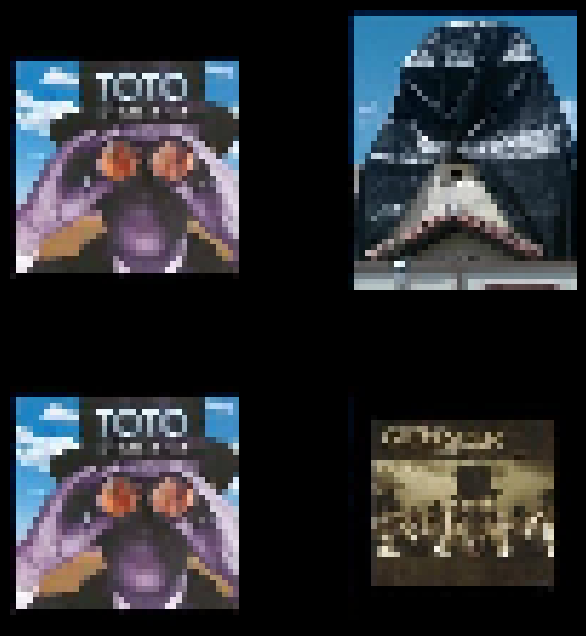

In [63]:
# Show image aaa and its most similar image
fig, axs = plt.subplots(2, 2, figsize=(8, 8), facecolor='black')
show(axs[0, 0], fig, 'train/all/{}.jpg'.format("aaa"))
show(axs[0, 1], fig, 'train/all/{}.jpg'.format(train_candidates.loc[0, train_candidates.columns[pred_ind]]))
show(axs[1, 0], fig, 'train/all/{}.jpg'.format("aaa"))
show(axs[1, 1], fig, 'train/all/{}.jpg'.format(train_candidates.loc[0, train_candidates.columns[true_col_idx]]))

### Import clip res50x4

In [2]:
train_folder = 'data/train/'
test_folder = 'data/test/'
csv_folder = 'data/'

train_csv = csv_folder + 'train.csv'
train_candidates_csv = csv_folder + 'train_candidates.csv'
test_candidates_csv = csv_folder + 'test_candidates.csv'

In [3]:
from clip import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model, transform = clip.load("RN50x4", device)

cpu


In [4]:
train_dataset = TrainDataset(train_csv, train_candidates_csv, train_folder+'left', train_folder+'all', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [8]:
import torchvision.transforms as transforms

# import image 'train/all/aaa.jpg' and preprocess it
img = mpimg.imread('data/train/all/aaa.jpg')
# convert to tensor with torch
t = transforms.Compose([transforms.ToPILImage(), 
                        transform, 
                        # add batch dimension
                        transforms.Lambda(lambda x: x.unsqueeze(0))])

print(img.shape)
img_t = t(img)
model.visual(img_t).detach().numpy().flatten().shape

(245, 200, 3)


(640,)

In [83]:
# Get number of files in data/train/all
import os
print(len(os.listdir('data/train/all')))

4000


In [26]:
# Make PCA on training data
from sklearn.decomposition import PCA
import glob
import time

def apply_model_on_all_images(model, transform, loader):
    """Make PCA on all images in data/train/all"""
    images = []
    start_time = time.time()
    # for i, data in enumerate(loader):
    #     # =============================================
    #     left, candidates, label = data
    #     cand_enc = [model(cand).detach().numpy().flatten() for cand in candidates]
    #     images += cand_enc
    #     # =============================================

    # One by one with blob
    count = 0
    for img_path in glob.glob('data/train/all/*.jpg'):
        img = mpimg.imread(img_path)
        img = transform(img)
        img_enc = model(img_t).detach().numpy().flatten()
        images.append(img_enc)
        count += 1

        if count%200 == 0:
            print(f"Processed: {count}, Elapsed time: ", time.time() - start_time)
            start_time = time.time()

    return images

images = apply_model_on_all_images(model.visual, t, train_loader)

KeyboardInterrupt: 

In [25]:
images[0].shape

torch.Size([1, 3, 288, 288])

In [13]:
# torch.save(images, 'data/train_images_enc.pt')
# images = torch.load('data/train_images_enc.pt')

In [18]:
# train pca on the images
# images_arr_flat = [np.asarray(image) for image in images]
# pca = PCA(n_components=256)
# pca.fit(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


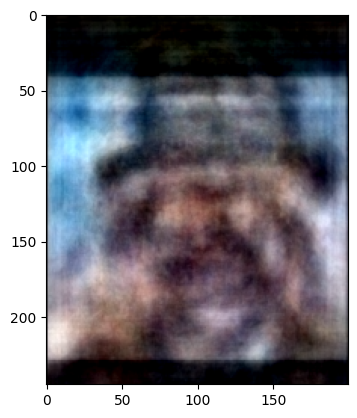

In [ ]:
# import image 'train/all/aaa.jpg' and preprocess it
img = mpimg.imread('data/train/all/aaa.jpg')
img_pca = pca.transform([img.flatten()])
img_pca = pca.inverse_transform(img_pca).reshape(245, 200, 3)/255.
plt.imshow(img_pca)

In [164]:
# Denormalize image
def denormalize_image(img):
    """Denormalize image"""
    img = img * 255.
    img = img.astype(np.uint8)
    return img

In [160]:
img.shape, img_pca.shape

((245, 200, 3), (245, 200, 3))

In [167]:
img_pca_t = t(denormalize_image(img_pca))
model.visual(img_pca_t).shape

torch.Size([1, 640])